In [1]:
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from random import shuffle
import numpy as np
import os
from PIL import Image
from torchvision import transforms
import random
import torch
import matplotlib.pyplot as plt
import torch.utils.data as data_utils

In [2]:
fc1_hidden = 1024
fc2_hidden = 512
fc3_hidden = 256
lstm_layers = 3
dropout_prob = 0
data_path = "data/data_30"

In [3]:
test_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])
    ])

In [4]:
def get_img_list(cat,d1):
    ret = list()
    for frame in os.listdir(data_path + '/{}/{}'.format(cat,d1)):
        img_pil = Image.open(data_path + '/{}/{}/{}'.format(cat,d1,frame))
        input_img = test_transform(img_pil)
        ret.append(input_img)
    return ret

# This sets the first 7 videos as val and the rest as train, which are the official train/test splits for UCF101
# https://www.crcv.ucf.edu/data/UCF101.php
def createTrainAndValSet(categories):
    category_options = sorted(os.listdir(data_path))
    category_names = category_options[:categories]
    train_set = []
    val_set = []
    i=0
    for cat in category_names:
        print(cat)
        for d1 in os.listdir(data_path + '/{}'.format(cat)):
            img_list = get_img_list(cat,d1)
            if int(d1[1:3]) >= 8:
                train_set.append((img_list,i))
            else:
                val_set.append((img_list,i))
        i+=1
    print("train_len", len(train_set), "val_len", len(val_set))
    return train_set,val_set

In [5]:
# Source: similar to the models used here: https://github.com/HHTseng/video-classification/blob/master/ResNetCRNN/functions.py
class LSTMModel(nn.Module):
    def __init__(self, output_size=5, batchSize=3):
        super(LSTMModel, self).__init__()

        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.output_size = output_size
        self.batchSize = batchSize
        self.resnet = nn.Sequential(*modules)

        
        self.fc1 = nn.Linear(resnet.fc.in_features, fc1_hidden)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(fc1_hidden, fc2_hidden)
    
        self.lstm = nn.LSTM(resnet.fc.in_features, resnet.fc.in_features, num_layers=lstm_layers, dropout=dropout_prob)
        self.hidden = (torch.randn(lstm_layers, self.batchSize, fc2_hidden).cuda(), 
torch.randn(lstm_layers, self.batchSize, fc2_hidden).cuda()) 
        
        self.fc3 = nn.Linear(fc2_hidden, fc3_hidden)
        self.fc4 = nn.Linear(fc3_hidden, output_size)
        
    def forward(self, x_3d):
        resnet = models.resnet18(pretrained=True)
        frame_list = []
        for frame in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, frame, :, :, :])  # ResNet
                x = x.view(x.size(0), -1)
            x = self.dropout(F.relu(self.fc1(x)))
            x = self.fc2(x)
            frame_list.append(x)
        x = torch.stack(frame_list).transpose(0, 1)

        self.hidden = (torch.randn(lstm_layers, self.batchSize, fc2_hidden).cuda(), 
torch.randn(lstm_layers, self.batchSize, fc2_hidden).cuda())
        x, self.hidden = self.lstm(x, self.hidden)
        
#       Using only the last output layer, because this is an LSTM
        x = self.dropout(F.relu(self.fc3(x[-1, :, :])))
        x = self.fc4(x)
        return x


In [6]:
def load_data(dataset, batchSize, shuffle_data=True):
    train_loader = []
    i = 0
    if shuffle_data:
        shuffle(dataset)
    while i + batchSize < len(dataset):
        batch_inputs = []
        batch_labels = []
        for j in range(batchSize):
            batch_inputs.append(torch.stack(dataset[i + j][0]))
            batch_labels.append(torch.tensor([dataset[i + j][1]]))
        
        batch_inputs = torch.stack(batch_inputs)
        batch_labels = torch.stack(batch_labels).squeeze()
        train_loader.append((batch_inputs, batch_labels))
        i += batchSize
    return train_loader

In [7]:
from random import shuffle

train_accuracies = []; train_losses = [];
val_accuracies = []; val_losses = [];

def train_model(model, loss_fn, optimizer, batchSize, epochs):
    model = model.cuda()
    loss_fn = loss_fn.cuda()
    
    train_loader = load_data(train_set, batchSize)
    val_loader = load_data(val_set, batchSize)
    
    print("training...")
    for epoch in range(epochs):
        correct = 0
        cum_loss = 0
        model.train()
        
        for (i, (inputs, target)) in enumerate(train_loader):
            frame_list = inputs.transpose(0, 1).cuda()
            
            scores = model(frame_list)            
            loss = loss_fn(scores, torch.tensor(np.array(target),dtype=torch.long).cuda())

            target = target.cuda()
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == target).sum().item()
            cum_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i + 1) % 5 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

        train_accuracies.append(correct / ((i + 1) * batchSize))
        train_losses.append(cum_loss / (i + 1))   
        
        correct = 0
        cum_loss = 0
        model.eval()
        
        for (i, (inputs, target)) in enumerate(val_loader):
            frame_list = inputs.transpose(0, 1).cuda()

            scores = model(frame_list)
            loss = loss_fn(scores, torch.tensor(np.array(target),dtype=torch.long).cuda())

            target = target.cuda()
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == target).sum().item()
            cum_loss += loss.item()
            
        print('Validation-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
               (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))
        
        val_accuracies.append(correct / ((i + 1) * batchSize))
        val_losses.append(cum_loss / (i + 1))

In [8]:
categories = 5

train_set, val_set = createTrainAndValSet(categories)

ApplyEyeMakeup
BabyCrawling
Biking
Billiards
BreastStroke
train_len 477 val_len 185


In [9]:
learning_rate = 5e-4
momentum = 0.5
weight_decay = 1e-4
batchSize= 46
epochs = 15

my_model = LSTMModel(output_size=categories, batchSize=batchSize)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

train_model(my_model, loss_fn, optimizer, batchSize, epochs)

training...
Train-epoch 0. Iteration 00005, Avg-Loss: 1.6093, Accuracy: 0.1870
Train-epoch 0. Iteration 00010, Avg-Loss: 1.6075, Accuracy: 0.2065
Validation-epoch 0. Iteration 00004, Avg-Loss: 1.5984, Accuracy: 0.2120
Train-epoch 1. Iteration 00005, Avg-Loss: 1.6046, Accuracy: 0.2217
Train-epoch 1. Iteration 00010, Avg-Loss: 1.6008, Accuracy: 0.2239
Validation-epoch 1. Iteration 00004, Avg-Loss: 1.6004, Accuracy: 0.2120
Train-epoch 2. Iteration 00005, Avg-Loss: 1.5481, Accuracy: 0.2826
Train-epoch 2. Iteration 00010, Avg-Loss: 1.6626, Accuracy: 0.2609
Validation-epoch 2. Iteration 00004, Avg-Loss: 1.6371, Accuracy: 0.1902
Train-epoch 3. Iteration 00005, Avg-Loss: 1.5676, Accuracy: 0.2435
Train-epoch 3. Iteration 00010, Avg-Loss: 1.5423, Accuracy: 0.2674
Validation-epoch 3. Iteration 00004, Avg-Loss: 3.2003, Accuracy: 0.2065
Train-epoch 4. Iteration 00005, Avg-Loss: 1.4834, Accuracy: 0.3739
Train-epoch 4. Iteration 00010, Avg-Loss: 1.5435, Accuracy: 0.3000
Validation-epoch 4. Iteration 

Data: 30 consecutive frames, from middle of video
Categories: 5
Model: LSTM
Loss Function: CrossEntropyLoss
Optimizer: Adam
Learning Rate: 0.0005
Momentum: 0.5
Weight Decay: 0.0001


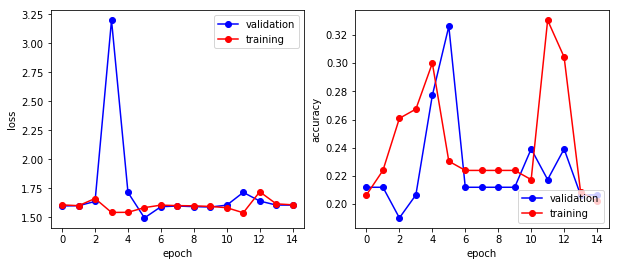

In [11]:
print("Data: 30 consecutive frames, from middle of video")
print("Categories:", categories)
print("Model: LSTM")
print("Loss Function: CrossEntropyLoss")
print("Optimizer: Adam")
print("Learning Rate:", learning_rate)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()